In [33]:
pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.8 MB/s eta 0:00:00


In [79]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
from __future__ import division
plt.rcParams["figure.figsize"] = (20,10)
import tqdm as tqdm
import time
from igraph import *
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time
from igraph import Graph
from igraph import Graph as IGraph


warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [80]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [81]:
books = []
for i in range(5):
    books.append(pd.read_csv('drive/MyDrive/lab4/asoiaf-book{}-edges.csv'.format(i+1)))

In [82]:
all_books = pd.concat(books)

In [83]:
all_books

Source                        Target  \
0                     Addam-Marbrand               Jaime-Lannister   
1                     Addam-Marbrand               Tywin-Lannister   
2                  Aegon-I-Targaryen            Daenerys-Targaryen   
3                  Aegon-I-Targaryen                  Eddard-Stark   
4    Aemon-Targaryen-(Maester-Aemon)                Alliser-Thorne   
..                               ...                           ...   
755                 Tyrion-Lannister                        Ysilla   
756                  Tywin-Lannister                Wylis-Manderly   
757                Victarion-Greyjoy                         Wulfe   
758      Walder-Frey-(son-of-Jammos)  Walder-Frey-(son-of-Merrett)   
759                           Yandry                        Ysilla   

           Type  weight  book  
0    Undirected       3   1.0  
1    Undirected       6   1.0  
2    Undirected       5   1.0  
3    Undirected       4   1.0  
4    Undirected       4   1.0  
..          ...     ...   ...  
755  undirected      11   5.0  
756  undirected       3   5.0  
757  undirected       3   5.0  
758  undirected      10   5.0  
759  undirected      14   5.0  

[3909 rows x 5 columns]

In [84]:
edges = all_books.groupby(['Source','Target']).agg({'weight':'sum'}).reset_index()

In [85]:
edges.sort_values('weight',ascending=False)

Source              Target  weight
1334           Eddard-Stark    Robert-Baratheon     334
2031               Jon-Snow       Samwell-Tarly     228
1965      Joffrey-Baratheon         Sansa-Stark     222
1972      Joffrey-Baratheon    Tyrion-Lannister     219
640              Bran-Stark               Hodor     209
...                     ...                 ...     ...
1809        Jaime-Lannister            Joy-Hill       3
1805        Jaime-Lannister            Jon-Snow       3
1802          Jafer-Flowers       Jaremy-Rykker       3
1801  Jaehaerys-I-Targaryen  Maegor-I-Targaryen       3
0            Addam-Marbrand       Brynden-Tully       3

[2823 rows x 3 columns]

In [86]:
GOT = nx.from_pandas_edgelist(edges,
                            source='Source',
                            target='Target',
                            edge_attr='weight' )

In [87]:
num_nodes = GOT.number_of_nodes()
num_edges = GOT.number_of_edges()
average_degree = sum(dict(GOT.degree()).values()) / len(GOT.nodes())
info = {
    'Number of nodes': num_nodes,
    'Number of edges': num_edges,
    'Avareages degress': average_degree
}
print(info)

{'Number of nodes': 796, 'Number of edges': 2823, 'Avareages degress': 7.092964824120603}


In [88]:
weighted_degrees = dict(nx.degree(GOT,weight='weight'))
max_degree = max(weighted_degrees.values())

In [89]:
import seaborn as sns

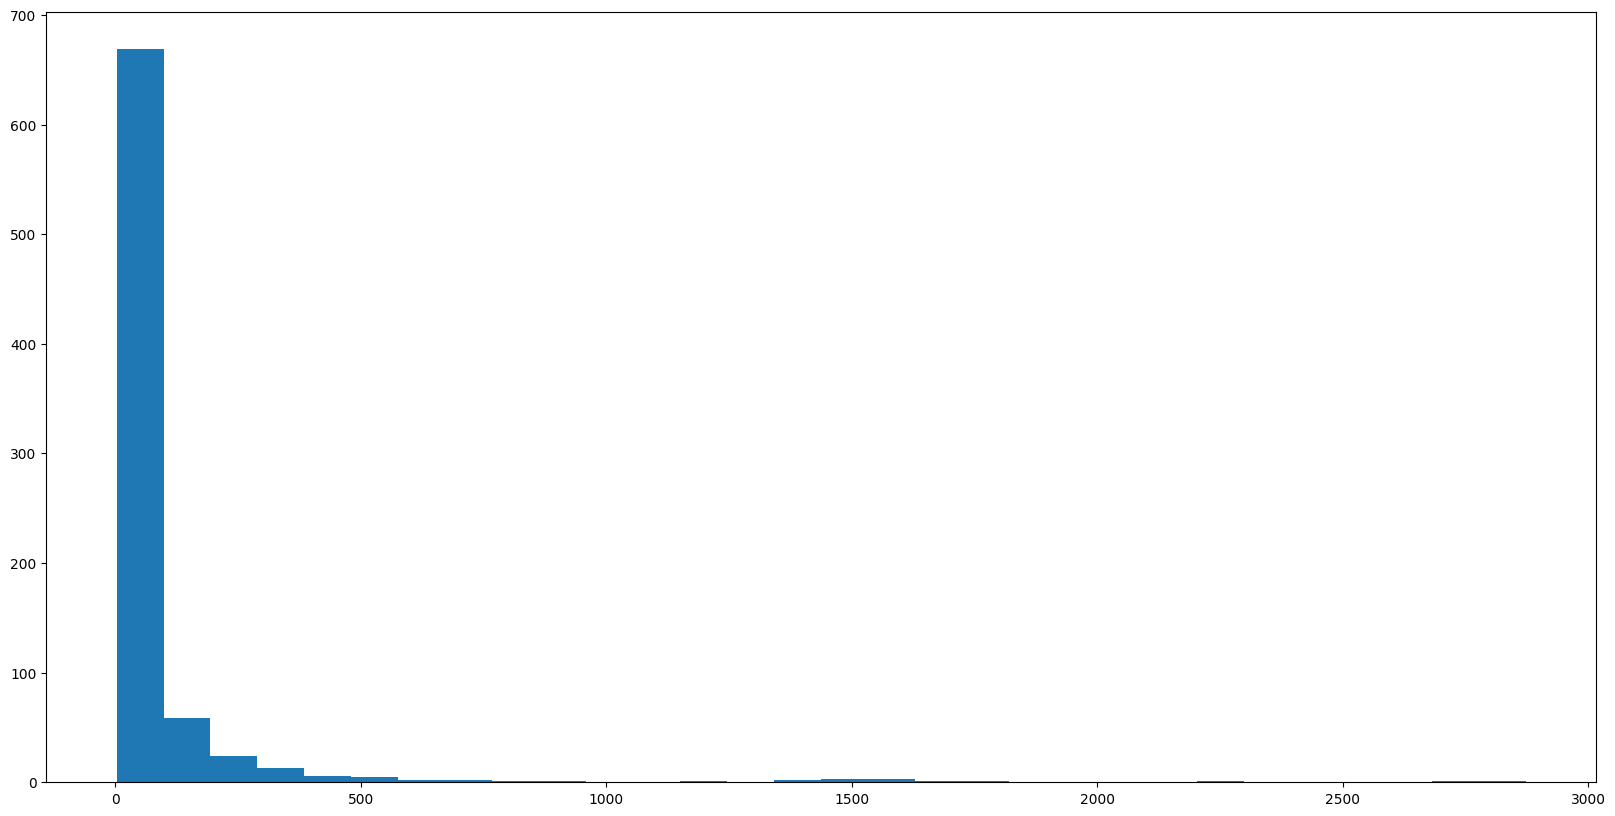

In [90]:
h = plt.hist(weighted_degrees.values(), bins = 30)

In [91]:
subG = GOT.subgraph([n for n in weighted_degrees if weighted_degrees[n]>200])

In [92]:
num_nodes = subG.number_of_nodes()
num_edges = subG.number_of_edges()
average_degree = sum(dict(subG.degree()).values()) / len(subG.nodes())
info = {
    'Number of nodes': num_nodes,
    'Number of edges': num_edges,
    'Avareages degress': average_degree
}
print(info)

{'Number of nodes': 63, 'Number of edges': 496, 'Avareages degress': 15.746031746031745}


In [93]:
pos = nx.spring_layout(subG,weight='weight',iterations=20, k = 4)

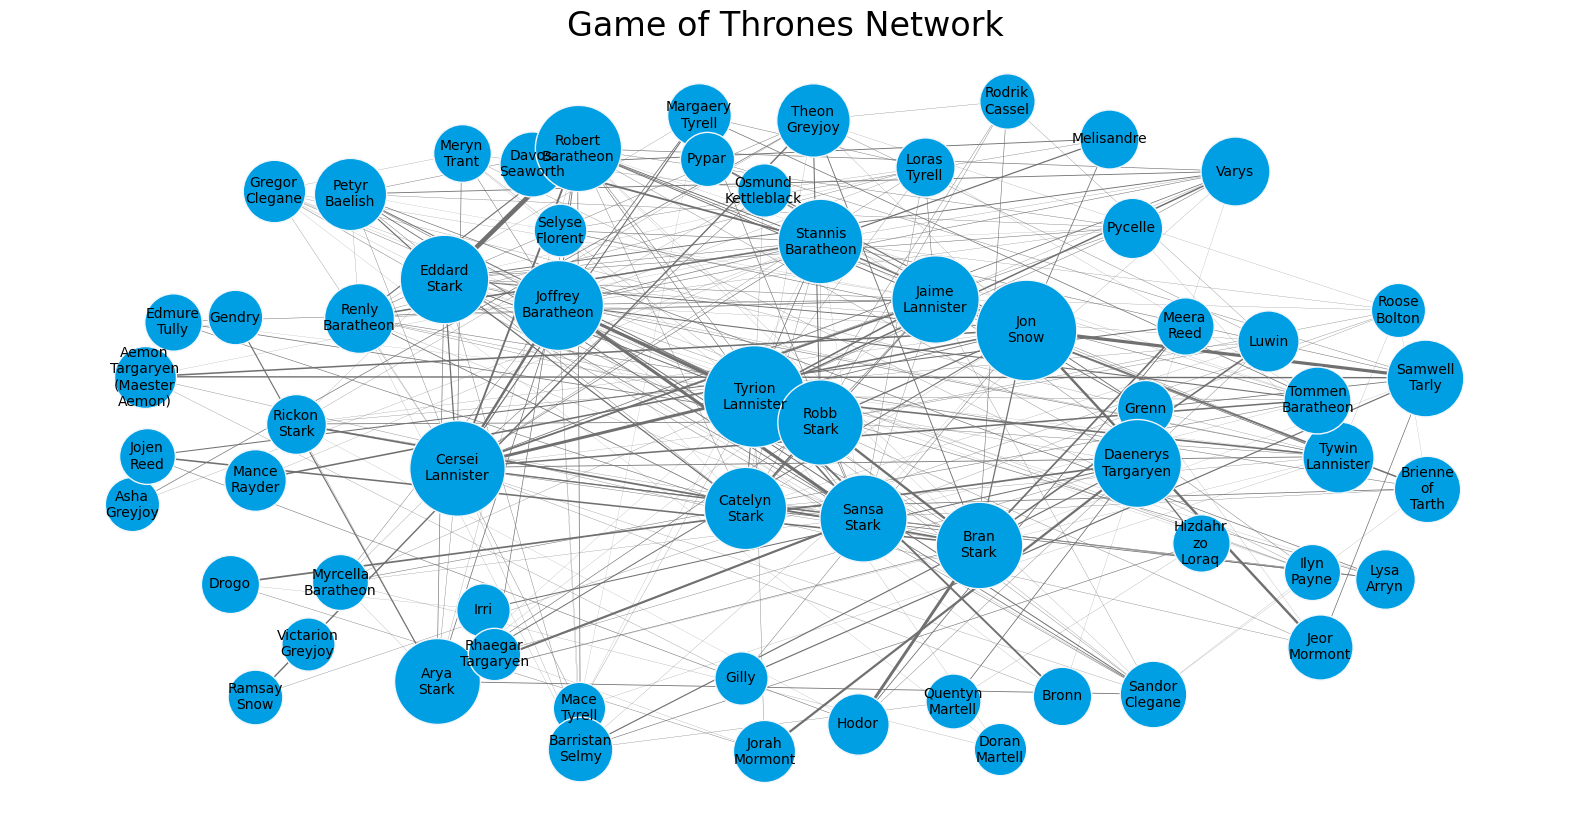

In [94]:
plt.axis('off')
plt.title('Game of Thrones Network',fontsize = 24)


for node in subG.nodes():
    size = 100*weighted_degrees[node]**0.5
    ns = nx.draw_networkx_nodes(subG,pos,nodelist=[node], node_size=size, node_color='#009fe3')
    ns.set_edgecolor('#f2f6fa')

nx.draw_networkx_labels(subG,pos,{n:n.replace('-','\n') for n in subG.nodes() if weighted_degrees[n]>100},font_size=10);

for e in subG.edges(data=True):
    if e[2]['weight']>10:
        nx.draw_networkx_edges(subG,pos,[e],width=e[2]['weight']/100,edge_color='#707070')

In [96]:
def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """

    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):

        # Simulate propagation process
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:

                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones) - set(A))

            # Add newly activated nodes to the set of activated nodes
            A += new_active

        spread.append(len(A))

    return(np.mean(spread))

In [97]:
def plot_G(G,pos,infection_times,t):
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    plt.figure()
    plt.axis('off')
    plt.title('Game of Thrones Network, t={}'.format(t),fontsize = 24)

    for node in G.nodes():
        size = 100*weighted_degrees[node]**0.5
        if node in current_infectious:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#feba02')
        elif infection_times.get(node,9999999)<t:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#f2f6fa')
        else:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#009fe3')
        ns.set_edgecolor('#f2f6fa')
    nx.draw_networkx_labels(G,pos,{n:n.replace('-','\n') for n in G.nodes() if weighted_degrees[n]>100},font_size=10);

    for e in G.edges(data=True):
        if e[2]['weight']>10:
            nx.draw_networkx_edges(G,pos,[e],width=e[2]['weight']/100,edge_color='#707070')


In [98]:
def nx_to_igraph(G_nx):
    # Tạo một đồ thị trống trong igraph
    G_ig = Graph(directed=G_nx.is_directed())

    # Thêm các đỉnh
    G_ig.add_vertices(list(G_nx.nodes))

    # Thêm các cạnh
    G_ig.add_edges(list(G_nx.edges))

    return G_ig

In [105]:
def greedy(g,k,p=0.1,mc=500):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()

    # Find k nodes with largest marginal gain
    for _ in range(k):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        for j in set(range(len(g.vs))) - set(S):

            # Get the spread
            s = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if s > best_spread:
                best_spread, node = s, j

        # Add the selected node to the seed set
        S.append(node)

        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)

In [106]:
def celf(g,k,p=0.1,mc=500):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """


        # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    # Calculate the first iteration sorted list
    start_time = time.time()
    marg_gain = [IC(g,[node],p,mc) for node in range(g.vcount())]

    # Create the sorted list of nodes and their marginal gain
    Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]

    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------

    for _ in range(k-1):

        check, node_lookup = False, 0

        while not check:

            # Count the number of times the spread is computed
            node_lookup += 1

            # Recalculate spread of top node
            current = Q[0][0]

            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

In [101]:
g = nx_to_igraph(subG)

In [113]:
for vertex in g.vs:
    print(f"Node ID: {vertex.index}, Node Attributes: {vertex.attributes()}")

Node ID: 0, Node Attributes: {'name': 'Asha-Greyjoy'}
Node ID: 1, Node Attributes: {'name': 'Eddard-Stark'}
Node ID: 2, Node Attributes: {'name': 'Bran-Stark'}
Node ID: 3, Node Attributes: {'name': 'Doran-Martell'}
Node ID: 4, Node Attributes: {'name': 'Loras-Tyrell'}
Node ID: 5, Node Attributes: {'name': 'Margaery-Tyrell'}
Node ID: 6, Node Attributes: {'name': 'Lysa-Arryn'}
Node ID: 7, Node Attributes: {'name': 'Grenn'}
Node ID: 8, Node Attributes: {'name': 'Meera-Reed'}
Node ID: 9, Node Attributes: {'name': 'Edmure-Tully'}
Node ID: 10, Node Attributes: {'name': 'Tyrion-Lannister'}
Node ID: 11, Node Attributes: {'name': 'Renly-Baratheon'}
Node ID: 12, Node Attributes: {'name': 'Rodrik-Cassel'}
Node ID: 13, Node Attributes: {'name': 'Luwin'}
Node ID: 14, Node Attributes: {'name': 'Hizdahr-zo-Loraq'}
Node ID: 15, Node Attributes: {'name': 'Theon-Greyjoy'}
Node ID: 16, Node Attributes: {'name': 'Mance-Rayder'}
Node ID: 17, Node Attributes: {'name': 'Sansa-Stark'}
Node ID: 18, Node Attrib

In [108]:
celf_output   = celf(g,3,p = 0.2,mc = 500)
greedy_output = greedy(g,3,p = 0.2,mc = 500)

# Print results
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))

celf output:   [1, 0, 2]
greedy output: [1, 0, 2]


In [117]:
infection_times = {'Eddard-Stark':-1,'Asha-Greyjoy':-1,'Bran-Stark':0}

In [115]:
def independent_cascade_of_author(G,t,infection_times):
    #doing a t->t+1 step of independent_cascade simulation
    #each infectious node infects neigbors with probabilty proportional to the weight
    max_weight = max([e[2]['weight'] for e in G.edges(data=True)])
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    for n in current_infectious:
        for v in G.neighbors(n):
            if v not in infection_times:
                if  G.get_edge_data(n,v)['weight'] >= np.random.random()*max_weight:
                    infection_times[v] = t+1
    return infection_times

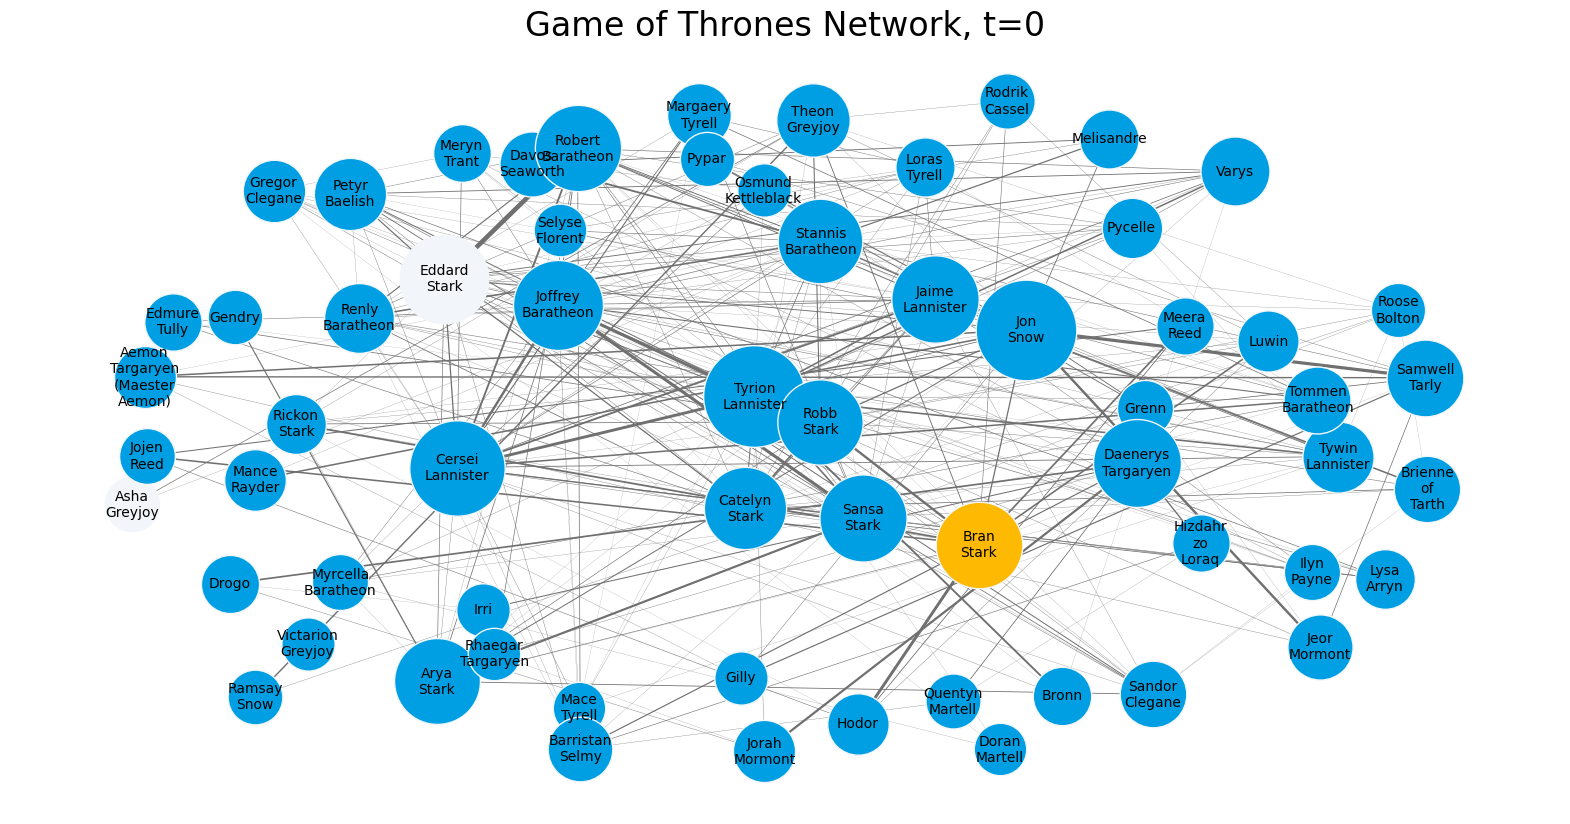

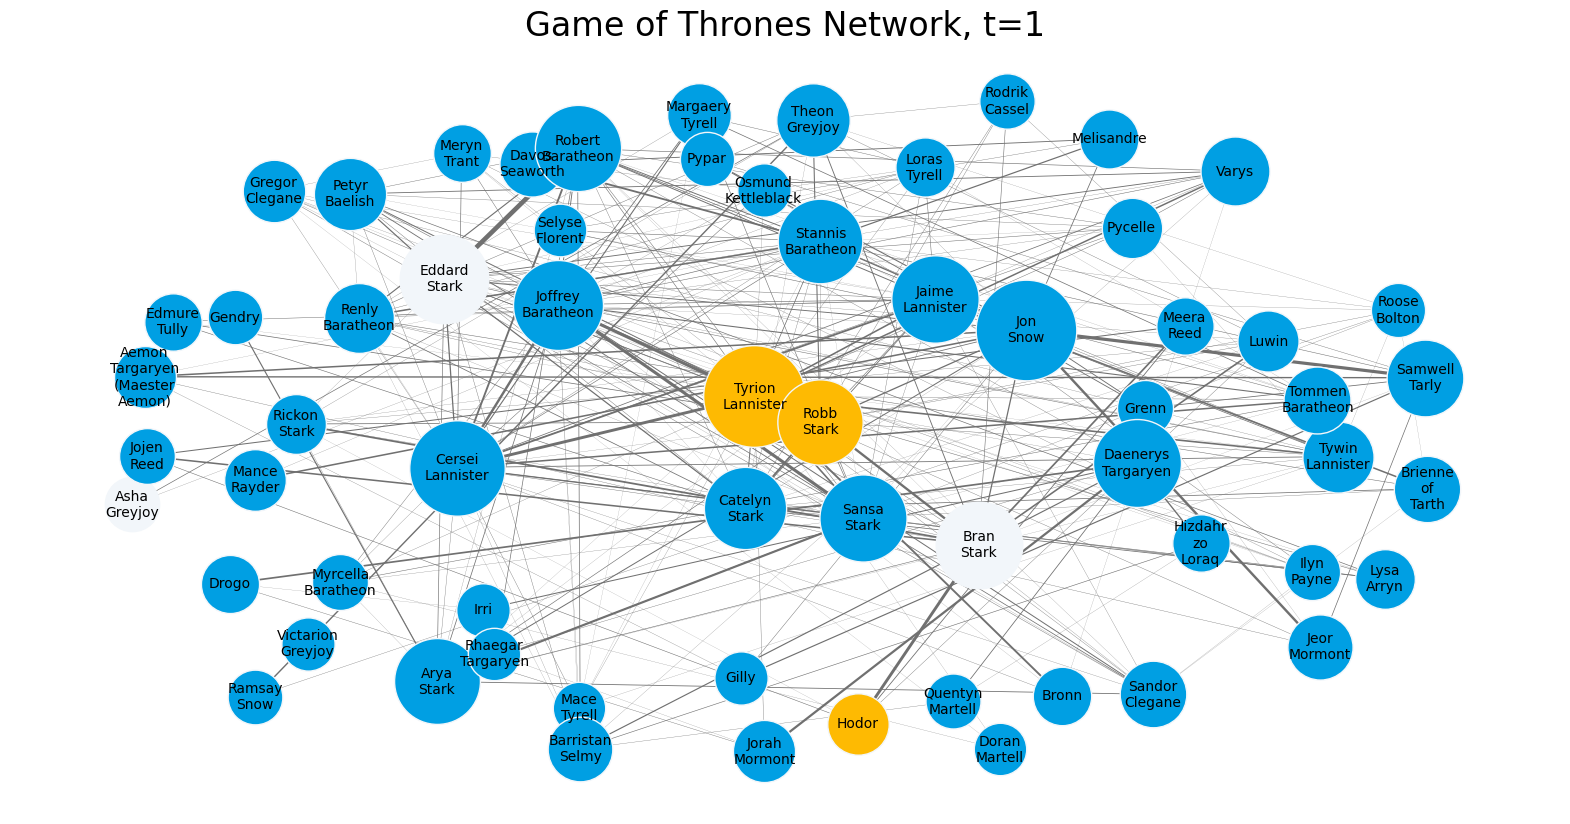

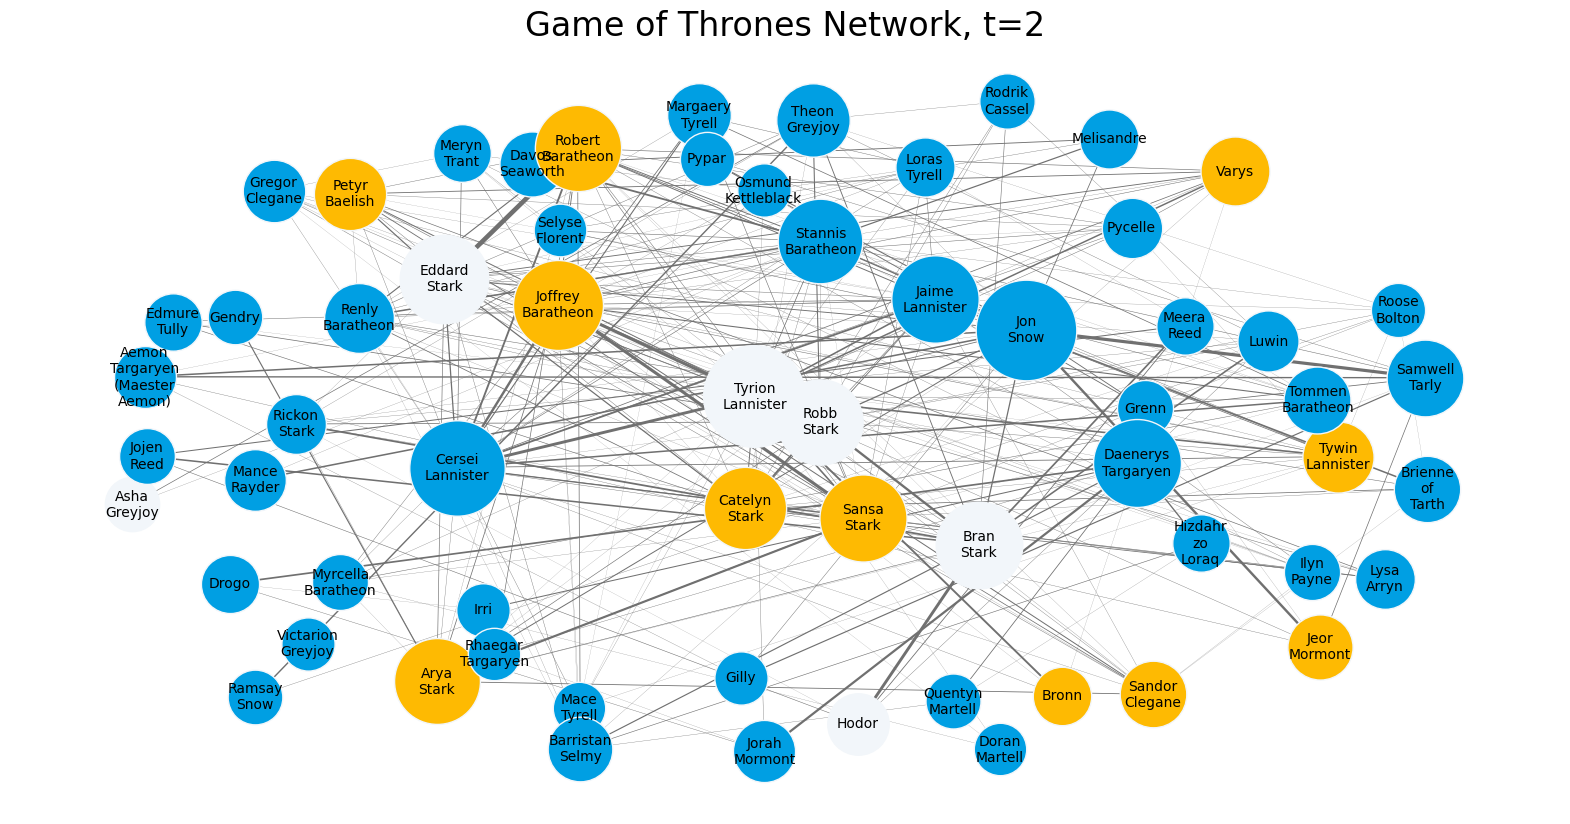

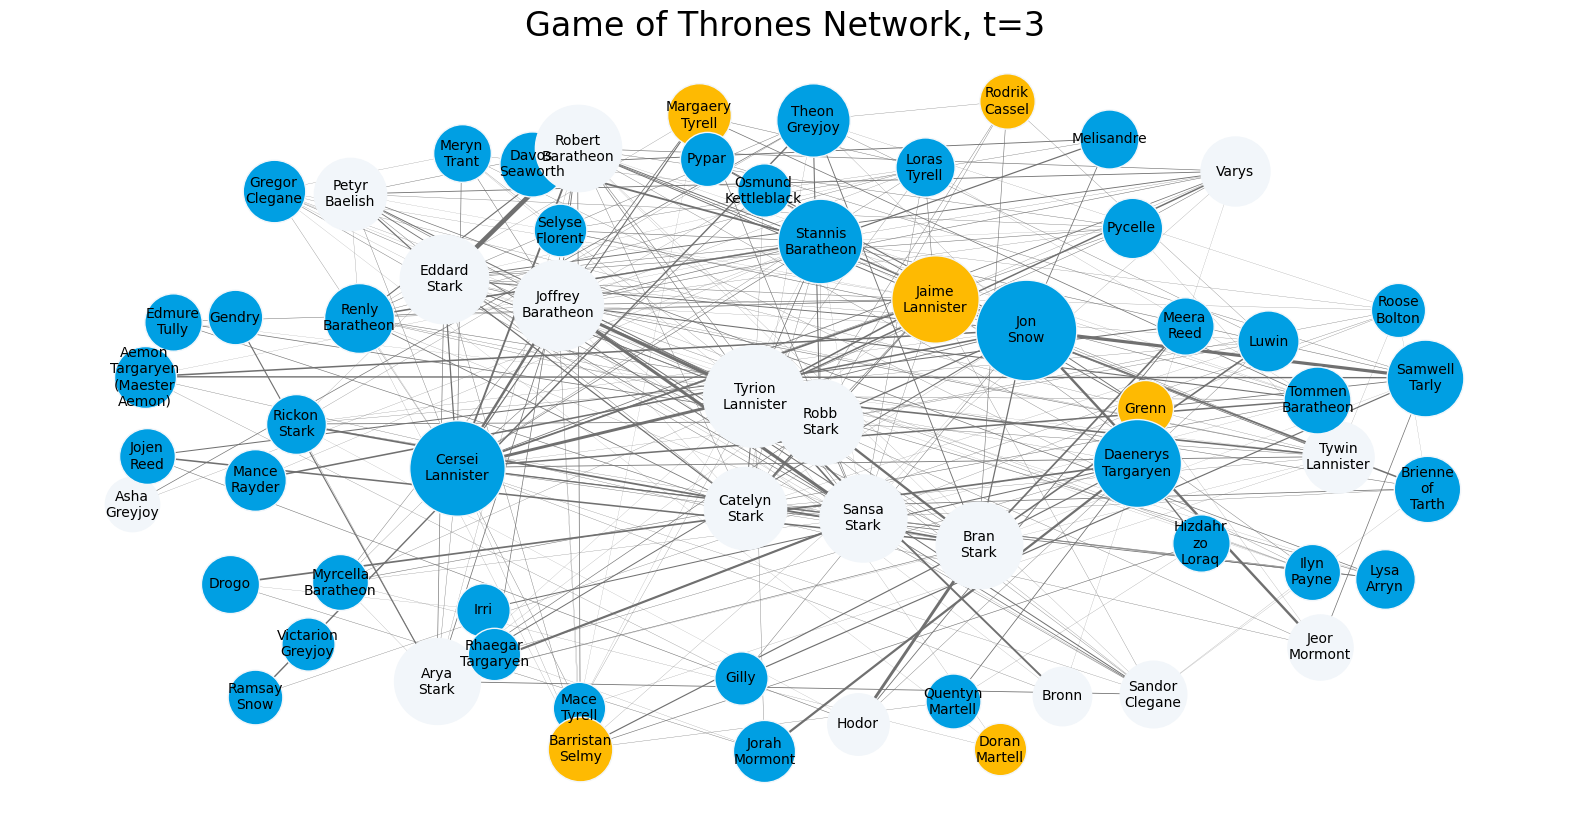

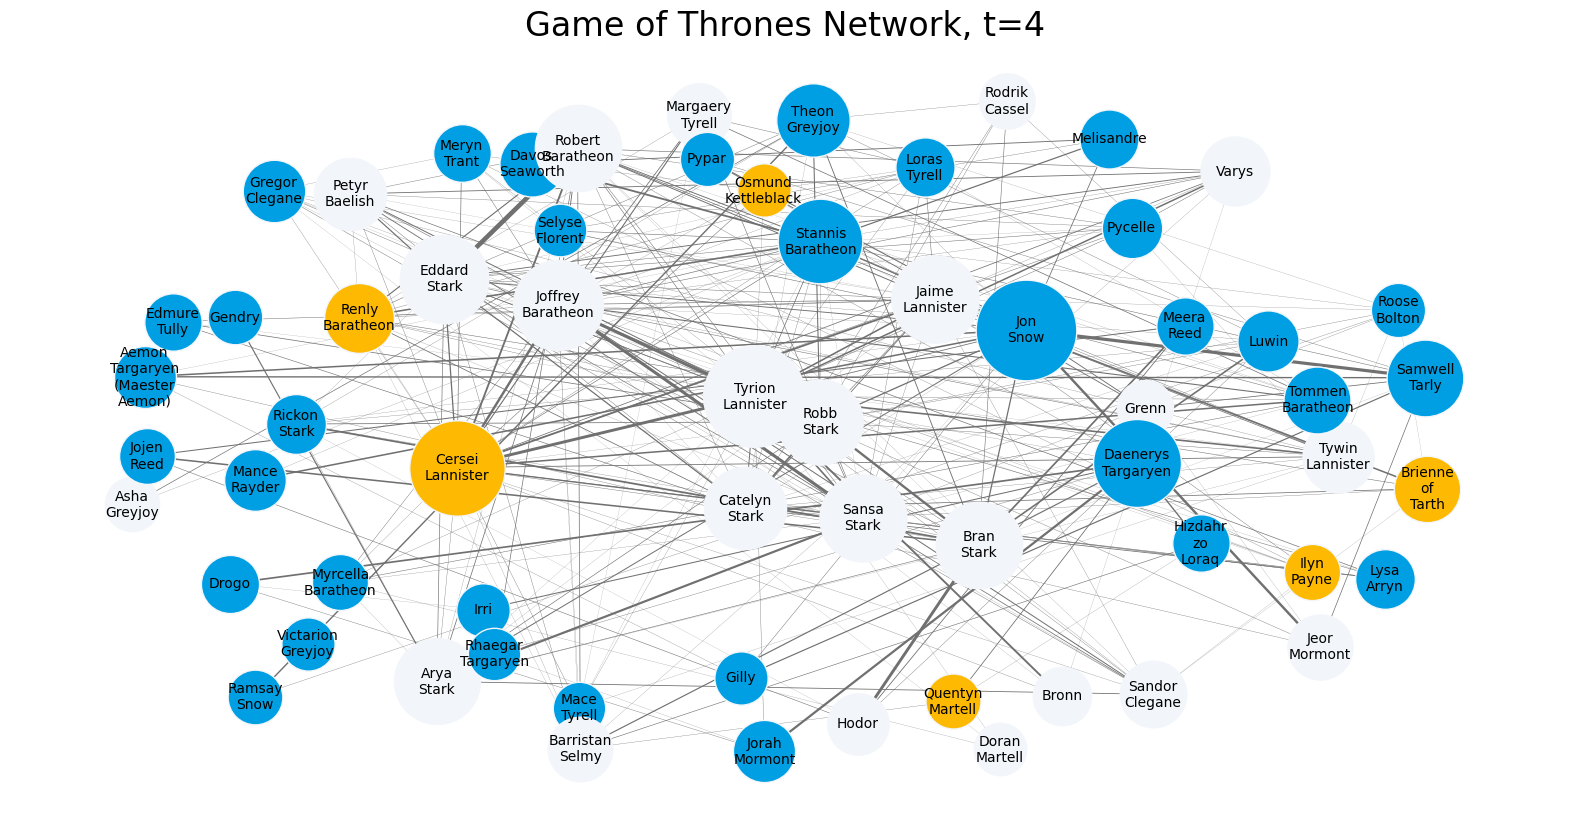

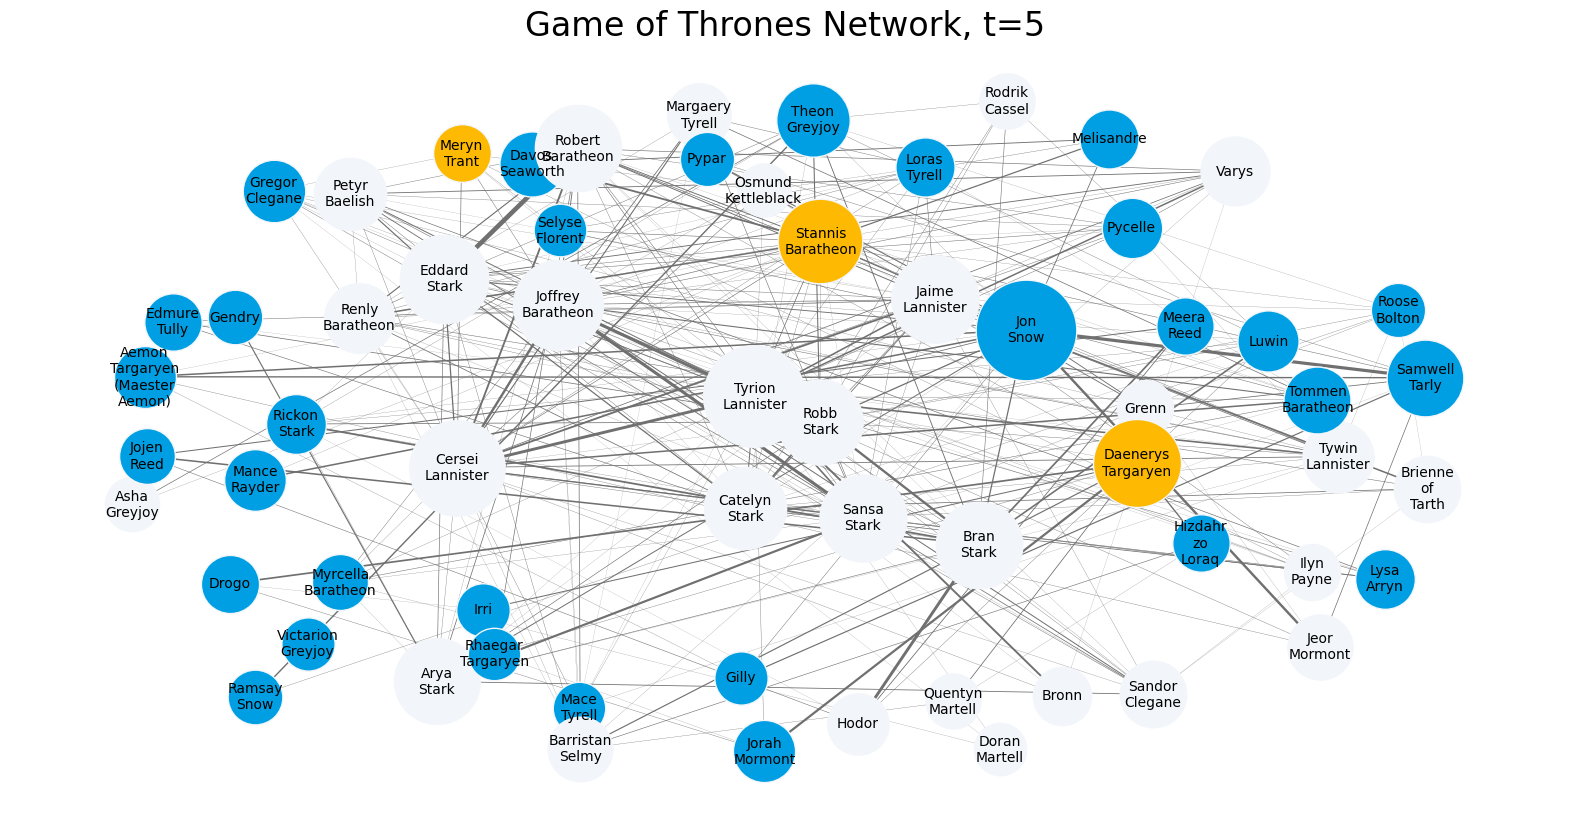

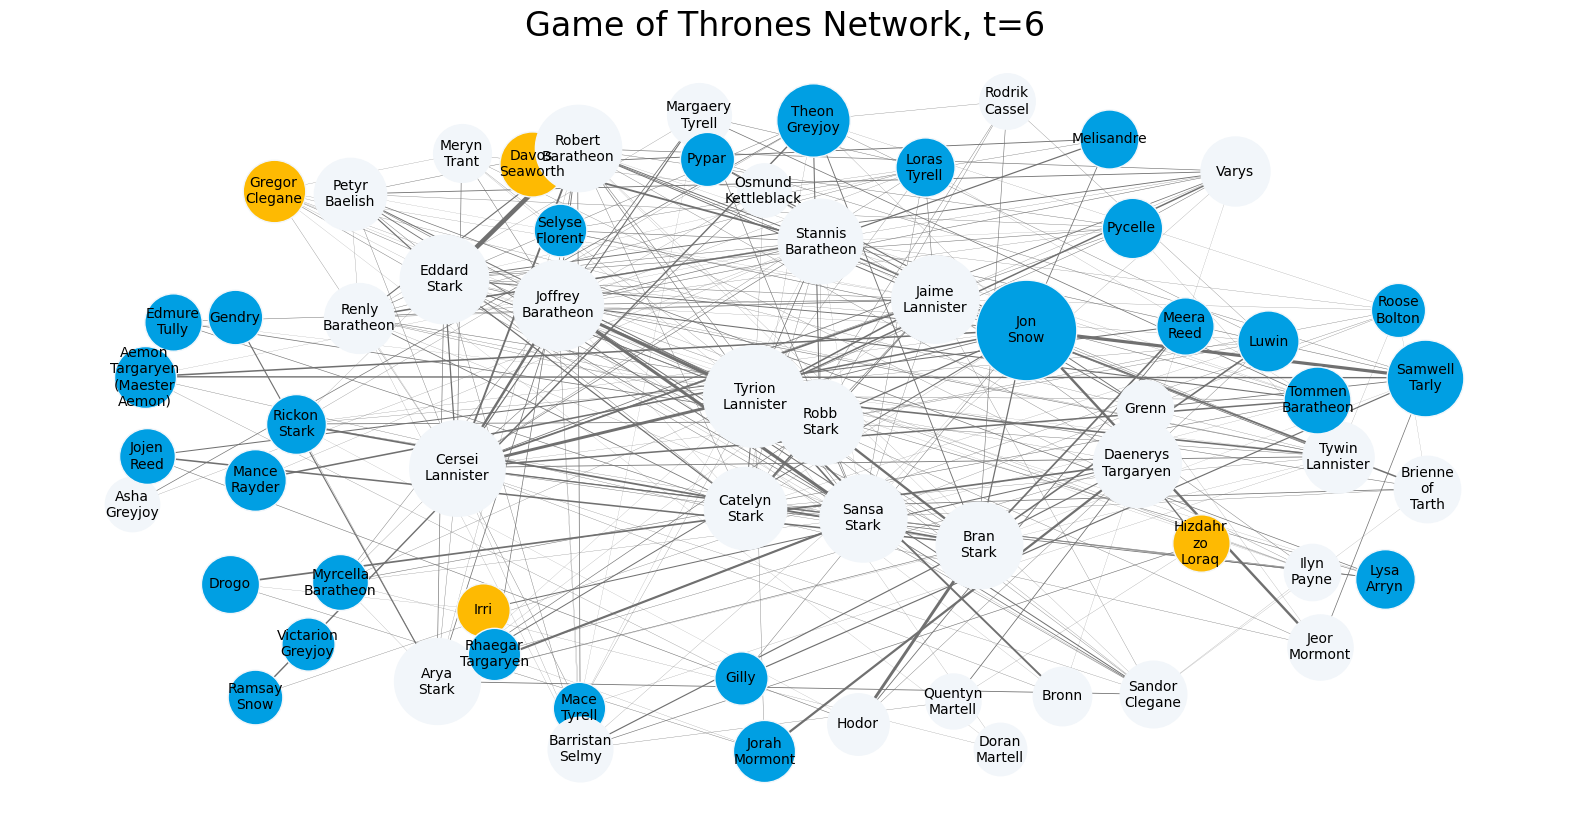

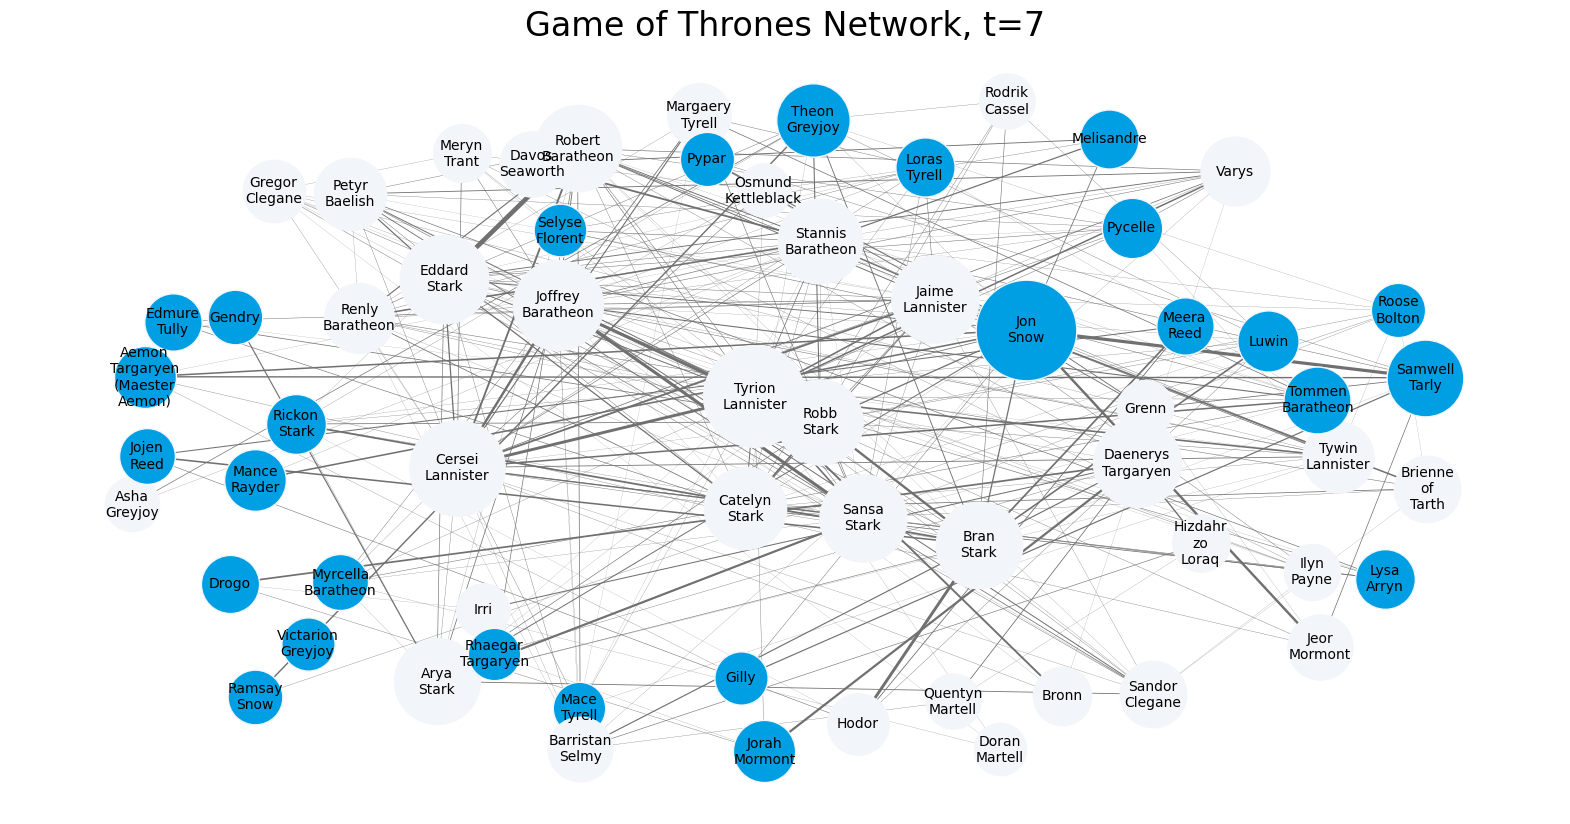

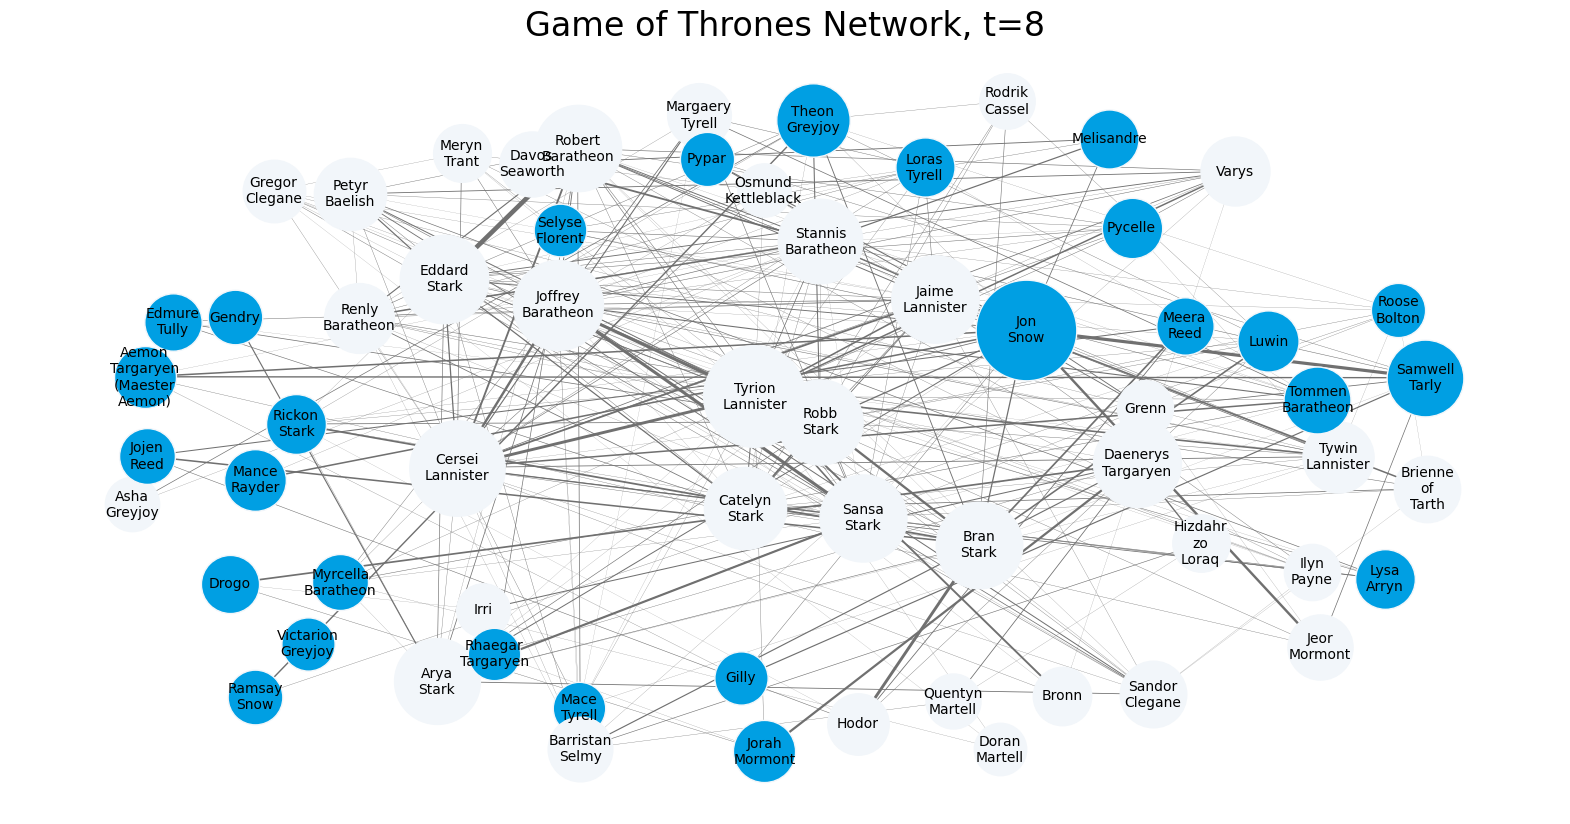

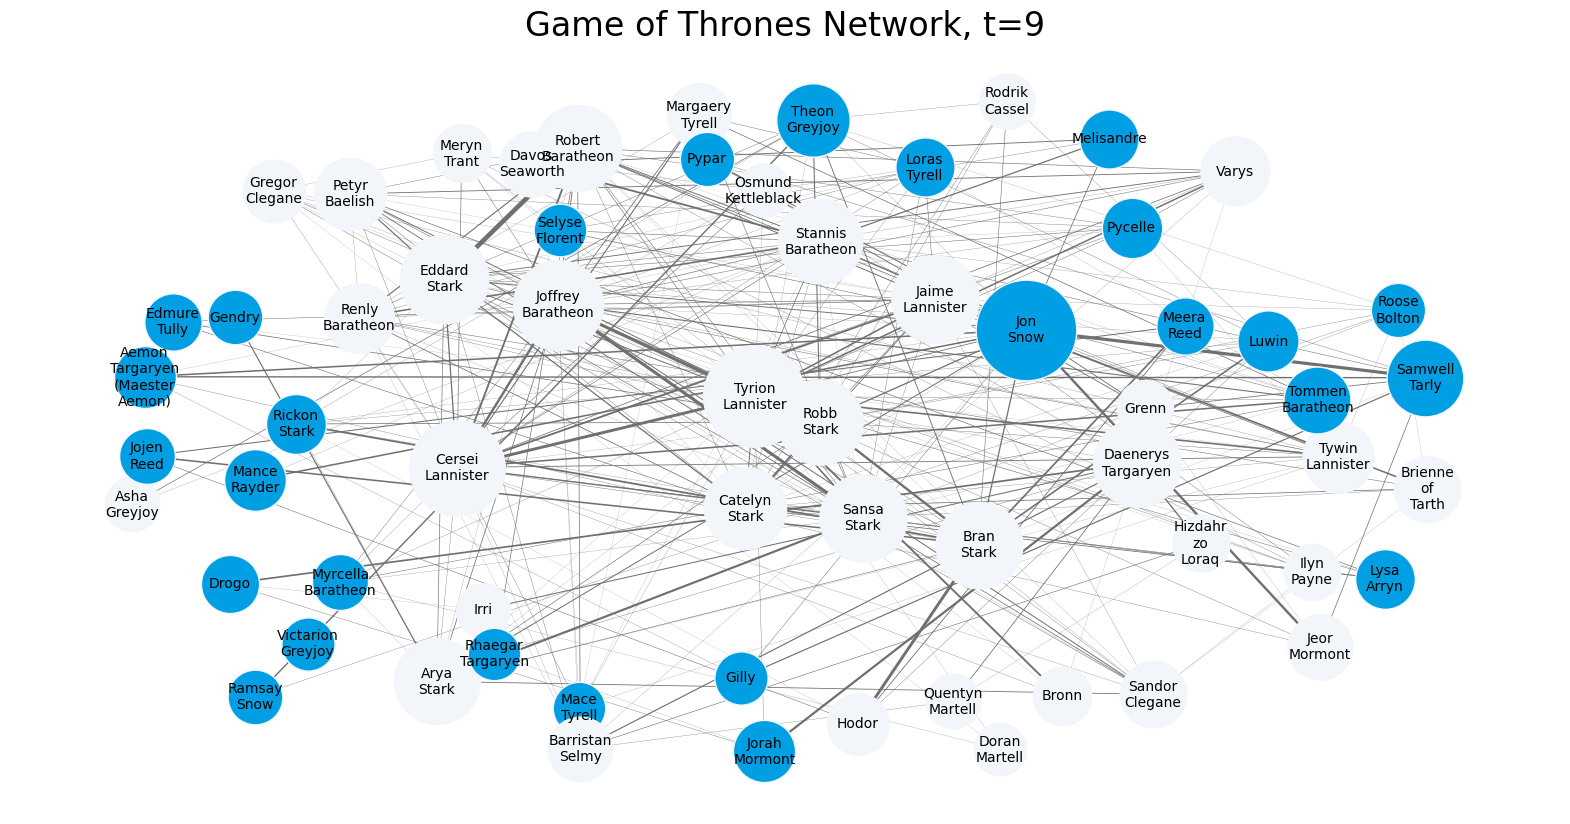

In [118]:
for t in range(10):
    plot_G(subG,pos,infection_times,t)
    infection_times = independent_cascade_of_author(subG,t,infection_times)